In [ ]:
eventsPath = os.environ["YAHOO_DATA"]
rawEventsRdd = sc.parallelize(sc.textFile(eventsPath + "/events.txt").take(100))
rawInstallsRdd = sc.parallelize(sc.textFile(eventsPath + "/installs.txt").take(100))
rawMergedRdd = rawEventsRdd.union(rawInstallsRdd)
def parseRawData(line):
    lineSplit = line.split("\t")
    return (lineSplit[0], #userid
              lineSplit[1], #itemid
              int(lineSplit[2]), #ts
              float(lineSplit[3]), #lat
              float(lineSplit[4]), #lon
              lineSplit[5], #city
              int(lineSplit[6]), #day_of_week
              int(lineSplit[7]), #time_of_day
              lineSplit[-1]) #event_type
    

eventsRdd = rawMergedRdd.map(parseRawData).cache()
#userIdConversionDictionary = eventsRdd.map(lambda x: x[0]).distinct().zipWithIndex().collectAsMap()
#itemIdConversionDictionary = eventsRdd.map(lambda x: x[1]).distinct().zipWithIndex().collectAsMap()
#cityConversionDictionary = eventsRdd.map(lambda x: x[5]).distinct().zipWithIndex().collectAsMap()
#USE the same id map always
import json
userIdConversionDictionary = json.load(open(eventsPath  + "/userIdConversionDictionary.txt"))
itemIdConversionDictionary = json.load(open(eventsPath  + "/itemIdConversionDictionary.txt"))
cityConversionDictionary = json.load(open(eventsPath  + "/cityConversionDictionary.txt"))
eventsConvertedRdd = eventsRdd.map(lambda x: (userIdConversionDictionary[x[0]],
    itemIdConversionDictionary[x[1]],
    x[2],
    x[3],
    x[4],
    cityConversionDictionary[x[5]],
    x[6],
    x[7],
    x[8]
    ))

eventsConvertedRdd.take(3)

# Graphs on app usage

In [6]:
onlyOpenEvents = rawEventsRdd.map(
    parseRawData).map(lambda x : (itemIdConversionDictionary[x[1]],1))
appvsruntime = onlyOpenEvents.reduceByKey(lambda a,b : a + b).sortBy(lambda x: x[1], ascending=False)
appvsruntime.take(3)


[(60075, 10), (55396, 8), (14861, 8)]

In [ ]:
import json
userappmap = json.load(open(eventsPath + "/userAppMap.txt"))
def findKey(d, v):
    for k, val in d.iteritems():
        if val == v:
            return k
listofapps = [ (findKey(itemIdConversionDictionary, v[0]), v[1]) for v in appvsruntime.take(100)]
stats_dir = eventsPath + "/stats/"
if not os.path.exists(stats_dir):
    os.makedirs(stats_dir)
numberOfEvents = float(appvsruntime.count())
outfile = open(stats_dir + "topapps_run_byusers.csv",'w')
outfile.write("App,#usersruntheapp, percentage\n")
for el in listofapps:
    outfile.write(str(el[0]) + "," + str(el[1]) + "," + str(el[1]/numberOfEvents) + '\n')
outfile.close()

### Number of open events vs application

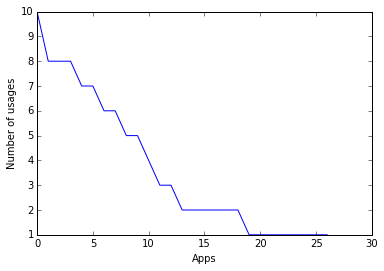

In [9]:
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline
data= appvsruntime.map(lambda x : x[1]).collect()
plt.plot(data)
plt.ylabel('Number of usages')
plt.xlabel('Apps')
figure_dir = eventsPath + "/figures/"
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)
plt.savefig(figure_dir + "numberofusagevsapp" + str(int(time.time())) + ".png")
plt.show()

### Percentage of usage over all events per app

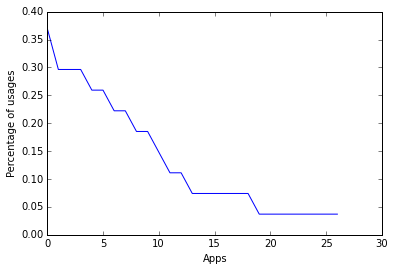

In [12]:
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline
try:
    data
except NameError:
    data= appvsruntime.map(lambda x : x[1]).collect()
itemCount = float(len(data))
plt.plot([el/itemCount for el in data])
plt.ylabel('Percentage of usages')
plt.xlabel('Apps')
figure_dir = eventsPath + "/figures/"
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)
plt.savefig(figure_dir + "percentageofusagevsapp" + str(int(time.time())) + ".png")
plt.show()

## Graphs of users installed per application

In [52]:
userappmaprdd = sc.parallelize([ (int(k), userappmap[k]) for k in userappmap.keys()])
userappmaprdd = userappmaprdd.flatMap(lambda x : [ (k, 1) for k in x[1] ] ) #(itemid, 1) format
userappmaprdd = userappmaprdd.reduceByKey(
    lambda a,b : a + b).sortBy(lambda x : x[1], ascending=False)

In [68]:
def findKey(d, v):
    for k, val in d.iteritems():
        if val == v:
            return k
listofapps = [ (findKey(itemIdConversionDictionary, v[0]), v[1]) for v in userappmaprdd.take(100)]
stats_dir = eventsPath + "/stats/"
if not os.path.exists(stats_dir):
    os.makedirs(stats_dir)
numberOfUsers = float(len(userappmap))
outfile = open(stats_dir + "topapps_owned_byusers.csv",'w')
outfile.write("App,#usersowntheapp, percentage\n")
for el in listofapps:
    outfile.write(str(el[0]) + "," + str(el[1]) + "," + str(el[1]/numberOfUsers) + '\n')
outfile.close()


### Number of users installed per application

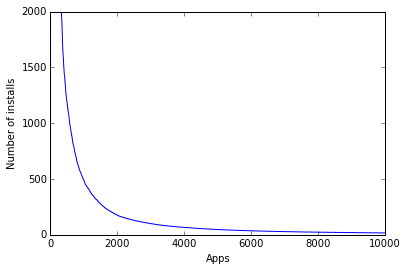

In [61]:
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline
dataiteminstall= userappmaprdd.map(lambda x : x[1]).collect()
plt.plot(dataiteminstall)
plt.ylabel('Number of installs')
plt.xlabel('Apps')
plt.axis([0,10000, 0, 2000])
figure_dir = eventsPath + "/figures/"
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)
plt.savefig(figure_dir + "numberofinstallperapp" + str(int(time.time())) + ".png")
plt.show()

### Percentage of users installed per application

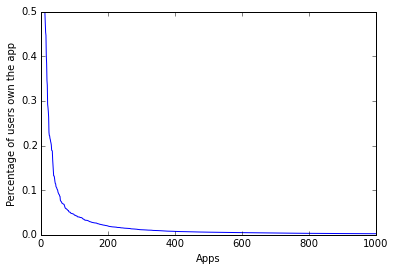

In [67]:
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline
try:
    dataiteminstall
except NameError:
    dataiteminstall= userappmaprdd.map(lambda x : x[1]).collect()
numberOfUsers = float(len(userappmap))
plt.plot([el/numberOfUsers for el in dataiteminstall])
plt.ylabel('Percentage of users own the app')
plt.xlabel('Apps')
plt.axis([0,1000, 0.0, 0.5])
figure_dir = eventsPath + "/figures/"
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)
plt.savefig(figure_dir + "percentageofusersownedvsapp" + str(int(time.time())) + ".png")
plt.show()

In [2]:
eventRDD = eventsConvertedRdd.groupBy(lambda x: x[0]).map(lambda (x,y): (x, sorted(list(y),key=lambda a: a[2])))
def tempRemoveUserIdDup(line):
    data = line[1]
    newData = [el[1:] for el in data]
    return line[0], newData
eventRDD2 = eventRDD.map(tempRemoveUserIdDup)

In [6]:
def splitRddMerged(line):
    open_events = [el for el in line[1] if el[7] == "App_Opened"]
    install_events = [el for el in line[1] if el[7] == "install"]
    uninstall_events = [el for el in line[1] if el[7] == "uninstall"]
    return line[0],open_events, install_events, uninstall_events
splited = eventRDD2.map(splitRddMerged)
splited.collect()

[(8,
  [(94, 1420963236, 47.237469, -122.530891, 6, 6, 0, u'App_Opened'),
   (51, 1420968301, 47.23745, -122.530884, 6, 6, 1, u'App_Opened'),
   (95, 1420968678, 47.23745, -122.530884, 6, 6, 1, u'App_Opened'),
   (78, 1420969386, 47.23745, -122.530884, 6, 6, 1, u'App_Opened'),
   (47, 1421009495, 47.237476, -122.530884, 6, 6, 12, u'App_Opened'),
   (95, 1421009504, 47.237476, -122.530884, 6, 6, 12, u'App_Opened'),
   (65, 1421009506, 47.237476, -122.530884, 6, 6, 12, u'App_Opened'),
   (29, 1421010378, 47.237495, -122.530807, 6, 6, 13, u'App_Opened'),
   (12, 1421010854, 47.237469, -122.530907, 6, 6, 13, u'App_Opened'),
   (94, 1421010856, 47.237469, -122.530907, 6, 6, 13, u'App_Opened'),
   (93, 1421015988, 47.237461, -122.530899, 6, 6, 14, u'App_Opened'),
   (79, 1421028599, 47.237442, -122.530899, 6, 6, 18, u'App_Opened'),
   (78, 1421029924, 47.237476, -122.530891, 6, 6, 18, u'App_Opened'),
   (79, 1421033306, 47.237484, -122.530716, 6, 6, 19, u'App_Opened'),
   (29, 1421037596, 47

In [4]:
outp = open(eventsPath + "/outputstat.txt","a")
import datetime
import time
outp.write("--------------------------------------------------------\n") #separator
outp.write(datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))
outp.write("\n")
numberofusers = splited.count()
outp.write("Number of users : " + str(numberofusers) + "\n")
install = eventsConvertedRdd.filter(lambda x : x[8]=="install").count()
uninstall = eventsConvertedRdd.filter(lambda x : x[8]=="uninstall").count()
app_open = eventsConvertedRdd.filter(lambda x : x[8]=="App_Opened").count()
outp.write("Number of events(install, uninstall, open, all) : " 
           + str((install, uninstall, app_open, install + uninstall + app_open)) + "\n")
outp.write("Average number of events per user(install, uninstall, open, all) : " 
           + str((install/float(numberofusers), uninstall/float(numberofusers), 
                  app_open/float(numberofusers), 
                  (install + uninstall + app_open)/float(numberofusers))) + "\n")
outp.close()

200